In [132]:
from _py.config import config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.patheffects as pe
from cycler import cycler

from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve


from sklearn.pipeline import Pipeline
import catboost as cb
import xgboost as xgb
import lightgbm as lgbm

------

In [2]:
train = pd.read_sql('SELECT*FROM train', config.engine, index_col='id')
test = pd.read_sql('SELECT*FROM test', config.engine, index_col='id')

target = train[config.target_name]
train = train.drop(config.target_name, axis=1)

In [3]:
BASE_ALL_FEATURES = train.columns.to_list()
BASE_CAT_FEATURES = train.select_dtypes(include=['object', 'category']).columns.to_list()
BASE_NUM_FEATURES = train.select_dtypes(include='number').columns.to_list()

In [136]:
orig = pd.read_sql(f'SELECT * FROM orig', config.engine)[BASE_ALL_FEATURES+[target.name]]
orig_target = orig[target.name]
# orig = orig.drop(target.name, axis=1)

----

In [4]:
GRUVBOX_COLORS = ["#c21161", "#ffec44"]

RC = {
    "figure.facecolor": "#1e222d", # задний фон фигуры
    "axes.facecolor": "#171b26", # фон графиков
    "grid.color": "#b4c2be", # цвет сетки
    "grid.alpha": 0.25, # прозрачность сетки
    "axes.edgecolor": "#e0e0e0", # Рамка
    "axes.linewidth": 0.8, # толщина рамки
    "legend.facecolor": "#323740", # цвет легенды
    "legend.labelcolor" : "ffffff", # Цвет текста на легендах
    "axes.titlecolor": "#ffffff", # Цвет текста в заголовке 
    "axes.labelcolor": "#ffffff", # мини заголовки осей
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    "xtick.color": "#ffffff",
    "ytick.color": "#ffffff",
    "axes.prop_cycle": cycler(color=GRUVBOX_COLORS),
}

-------------

In [5]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features=None):
        self.cat_features = cat_features
        
    def fit(self, X, y=None):
        self.cat_features_ = self.cat_features or X.select_dtypes(include=['object', 'bool'])

        self.is_fitted_ = True 
        return self
        
    def transform(self, X):
        X_out = X.copy()
        for col in self.cat_features_:
            X_out[col] = X_out[col].astype('category')
        return X_out

In [6]:
class Trainer:
    def __init__(self, estimators, final_estimator=None, cv=None, cv_meta=None, seed=None, verbose=False):
        self.estimators = estimators
        self.final_estimator = final_estimator or LogisticRegression()
        self.seed = seed
        self.cv = cv or StratifiedKFold(n_splits=10, shuffle=True, random_state=self.seed)
        self.cv_meta = cv_meta or StratifiedKFold(n_splits=10, shuffle=True, 
                                                   random_state=(self.seed*2 if self.seed is not None else self.seed))
        self.verbose = verbose
    def train(self, X, y):
        self.__X, self.__y = X.copy(), y.copy()
        
        self.estimators_, self.oof = self.__train_base_models(self.__X, self.__y, self.estimators)
        self.final_estimator_, self.oof_meta = self.__train_meta_model(self.oof, self.__y)
        
    def evaluate(self, X, proba=True):
        df_preds = pd.DataFrame()
        for name, estimator in self.estimators_:
            y_pred_proba = estimator.predict_proba(X)[:, 1]
            df_preds[name] = y_pred_proba
        res = self.final_estimator_.predict_proba(df_preds)[:, 1]
        if proba:
            return res
        else:
            return (res>0.5).astype(int)
        
    def add(self, estimators):
        new_estimators, new_oof = self.__train_base_models(self.__X, self.__y, estimators)
        
        self.estimators_ += new_estimators
        self.oof = self.oof.join(new_oof)

        self.final_estimator_, self.oof_meta = self.__train_meta_model(self.oof, self.__y)
        
    def remove(self, estimator_name):
        self.oof = self.oof.drop(estimator_name, axis=1)
        self.estimators_ = [(name, est) for name, est in self.estimators_ if name != estimator_name]
        self.final_estimator_, self.oof_meta = self.__train_meta_model(self.oof, self.__y)
        
    def __train_base_models(self, X, y, estimators):
        oof_proba = np.zeros( (X.shape[0], len(estimators)), dtype=float )
        trained_estimators = []
        for i, (name, estimator) in enumerate(estimators):
            for n_fold, (train_id, valid_id) in enumerate(self.cv.split(X, y)):
                X_train = X.iloc[train_id].copy()
                y_train = y.iloc[train_id]
                X_valid = X.iloc[valid_id].copy()
                y_valid = y.iloc[valid_id]
                
                estimator_ = clone(estimator)
                estimator_.fit(X_train, y_train)
                
                y_pred_proba = estimator_.predict_proba(X_valid)[:, 1]
                oof_proba[valid_id, i] = y_pred_proba

                if self.verbose:
                    print(f'[{name}] training fold {n_fold+1} | roc_auc: {roc_auc_score(y_valid, y_pred_proba):.4f}') 
            if self.verbose:
                print('------')
                print(f'[{name}] OOF roc_auc: {roc_auc_score(self.__y, oof_proba[:, i]):.4f}')
                print(f'[{name}] retraining on full dataset') 
                print('________________________________________') 
                
            estimator_ = clone(estimator)
            estimator_.fit(X, y)
            trained_estimators.append( (name, estimator_) )
        oof = pd.DataFrame(oof_proba, columns=[estimators[i][0] for i in range(len(estimators))])
        return trained_estimators, oof
        
    def __train_meta_model(self, X,  y):
        meta_oof_proba = np.zeros(X.shape[0], dtype=float)
        for n_fold, (train_id, valid_id) in enumerate(self.cv_meta.split(X, y)):
            X_train = X.iloc[train_id].copy()
            y_train = y.iloc[train_id]
            X_valid = X.iloc[valid_id].copy()
            y_valid = y.iloc[valid_id]

            estimator_ = clone(self.final_estimator)
            estimator_.fit(X_train, y_train)
            meta_oof_proba[valid_id] = estimator_.predict_proba(X_valid)[:, 1]
            
        final_estimator_ = clone(self.final_estimator)
        final_estimator_.fit(X, y)
        meta_oof = pd.Series(meta_oof_proba, name='meta_model')

        if self.verbose:
            print(f'[Ensemble] OOF roc_auc: {roc_auc_score(self.__y, meta_oof):.4f}') # verbose
        
        return final_estimator_, meta_oof
        
    
    def plot_evaluation(self, test=None):
        with sns.axes_style("darkgrid", rc=RC):
            with plt.rc_context(RC):    
                
                plt.figure(figsize=(8, 6))
                sns.kdeplot(self.oof_meta, fill=True, label='OOF Predictions (Train)', alpha=0.25)
                if test is not None:
                    sns.kdeplot(self.evaluate(test), fill=True, label='Test Predictions', alpha=0.25)
                plt.title('Distribution of Predictions: OOF vs Test')
                plt.xlabel('Predicted Probability')
                plt.ylabel('Density')
                plt.legend()
                plt.show()
 
    def plot_score(self, figsize=None):
        with sns.axes_style("darkgrid"):
            with plt.rc_context(RC):
                
                figsize = figsize or (8, 6)
                base_scores = self.oof.apply(lambda col: roc_auc_score(self.__y, col))
                meta_score = roc_auc_score(self.__y, self.oof_meta)
                all_values = base_scores.to_list() + [meta_score]
                right_limit = max(all_values) + max(all_values) * 0.1
            
                fig, ax = plt.subplots(figsize=figsize)
                ax.barh(base_scores.index, base_scores.values, color='#ffec44', alpha=0.75)
                ax.barh('ensemble', meta_score, color='#c21161', alpha=0.75)
                ax.set_xlim((0, right_limit))
                ax.set_xlabel("ROC-AUC")
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt="%.4f",
                        color='white',
                        fontsize=11,
                        padding=5,
                        weight='bold',
                        label_type='edge',
                        path_effects=[
                            pe.Stroke(linewidth=0.9, foreground='black'),
                            pe.Normal()
                        ]
                    )
            
                ax.set_title("ROC-AUC of Base Models and Ensemble")
                plt.show()
        
    def plot_curve(self):
        with sns.axes_style("darkgrid", rc=RC):
            with plt.rc_context(RC):    
                
                cmap = LinearSegmentedColormap.from_list("my_cmap", ["#c21161", '#e0e0e0' ,"#ffec44"])
                plt.figure(figsize=(8, 6))
                for i, col in enumerate(self.oof.columns): 
                    color = cmap(i / (len(self.oof.columns) if len(self.oof.columns) > 1 else 1.0))
                    fpr, tpr, _ = roc_curve(self.__y, self.oof[col]) 
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label = f'{col}: {roc_auc:.4f}', color=color)
                fpr, tpr, _ = roc_curve(self.__y, self.oof_meta) 
                roc_auc = auc(fpr, tpr)
                
                plt.plot(fpr, tpr, label=f'ensemble: {roc_auc:.4f}', color='green', linewidth=2)
                plt.plot([0, 1], [0, 1],'--', color='white', linewidth=2.2)
                
                plt.title('Receiver Operating Characteristic') 
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.legend(loc = 'lower right')
                plt.xlim((0, 1))
                plt.ylim((0, 1))
                plt.show()

In [139]:
params_cb = {
    'task_type': 'GPU',
    'iterations': 800, 
    'cat_features': BASE_CAT_FEATURES,
    'verbose': 0,
    'random_state': 0,
}
params_xgb = {
    'device': 'gpu',
    'n_estimators': 800,
    'enable_categorical': True,
    'verbosity': 0,
    'seed': 0,
}
params_lgbm = {
    'device': 'gpu',
    'n_estimators': 800,
    'verbose': -1,
    'seed': 0
}
# --------------------------------------------------------
model_cb = cb.CatBoostClassifier(**params_cb)

pipe_lgbm = Pipeline([
    ('prep', CategoricalTransformer()),
    ('model',lgbm.LGBMClassifier(**params_lgbm))
])

pipe_xgb = Pipeline([
    ('prep', CategoricalTransformer()),
    ('model',xgb.XGBClassifier(**params_xgb))
])

In [140]:
estimators = [
    ('CAT', model_cb),
    ('XGB', pipe_xgb),
    ('LGBM', pipe_lgbm)
]

In [141]:
def create_orig_features(train, test):
    new_features_names = []
    train_eng = train.copy()
    test_eng = test.copy()
    
    for col in BASE_ALL_FEATURES:
        # MEAN BASED ON ORIG
        mean_map = orig.groupby(col)[target.name].mean()
        new_mean_col_name = f'orig_mean_{col}'
        mean_map.name = new_mean_col_name
    
        train_eng = train_eng.merge(mean_map, on=col, how='left')
        test_eng = test_eng.merge(mean_map, on=col, how='left')
        
        new_features_names.append(new_mean_col_name)
        
        # COUNT BASED ON ORIG
        count_map = orig.groupby(col)[target.name].count()
        new_count_col_name = f'orig_count_{col}'
        count_map.name = new_count_col_name
        
        train_eng = train_eng.merge(count_map, on=col, how='left')
        test_eng = test_eng.merge(count_map, on=col, how='left')
        
        new_features_names.append(new_count_col_name)
    print(f'{len(new_features_names)} orig base features created')
    
    for col in new_features_names:
        if 'mean' in col:
            train_eng[col] = train_eng[col].fillna(orig[target.name].mean())
            test_eng[col] = test_eng[col].fillna(orig[target.name].mean())
        else:
            train_eng[col] = train_eng[col].fillna(0)
            test_eng[col] = test_eng[col].fillna(0)
    return train_eng, test_eng

In [137]:
train_eng, test_eng = create_orig_features(train, test)

48 orig base features created


In [138]:
train_eng

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,orig_mean_smoking_status,orig_count_smoking_status,orig_mean_employment_status,orig_count_employment_status,orig_mean_family_history_diabetes,orig_count_family_history_diabetes,orig_mean_hypertension_history,orig_count_hypertension_history,orig_mean_cardiovascular_history,orig_count_cardiovascular_history
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,0.600069,20176,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,0.599569,59813,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,0.599569,59813,0.595285,21761,0.548572,78059,0.592178,74920,0.595699,92080
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,0.600069,20176,0.601512,60175,0.548572,78059,0.623285,25080,0.595699,92080
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,0.599569,59813,0.595285,21761,0.548572,78059,0.623285,25080,0.595699,92080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,29,1,59,6.9,5.2,1.5,26.1,0.88,133,57,...,0.601119,20011,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
699996,46,2,72,7.7,7.7,3.8,25.5,0.85,106,85,...,0.601119,20011,0.601512,60175,0.548572,78059,0.592178,74920,0.649747,7920
699997,35,1,50,5.6,6.1,6.4,26.9,0.88,127,84,...,0.599569,59813,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
699998,49,2,70,5.7,6.9,4.7,25.2,0.86,116,67,...,0.599569,59813,0.595285,21761,0.548572,78059,0.592178,74920,0.595699,92080


In [143]:
tr = Trainer(estimators=estimators, verbose=True)
tr.train(train_eng, target)

[CAT] training fold 1 | roc_auc: 0.7248
[CAT] training fold 2 | roc_auc: 0.7289
[CAT] training fold 3 | roc_auc: 0.7303
[CAT] training fold 4 | roc_auc: 0.7321
[CAT] training fold 5 | roc_auc: 0.7274
[CAT] training fold 6 | roc_auc: 0.7309
[CAT] training fold 7 | roc_auc: 0.7290
[CAT] training fold 8 | roc_auc: 0.7292
[CAT] training fold 9 | roc_auc: 0.7294
[CAT] training fold 10 | roc_auc: 0.7289
------
[CAT] OOF roc_auc: 0.7291
[CAT] retraining on full dataset
________________________________________
[XGB] training fold 1 | roc_auc: 0.7170
[XGB] training fold 2 | roc_auc: 0.7141
[XGB] training fold 3 | roc_auc: 0.7124
[XGB] training fold 4 | roc_auc: 0.7135
[XGB] training fold 5 | roc_auc: 0.7148
[XGB] training fold 6 | roc_auc: 0.7118
[XGB] training fold 7 | roc_auc: 0.7162
[XGB] training fold 8 | roc_auc: 0.7112
[XGB] training fold 9 | roc_auc: 0.7144
[XGB] training fold 10 | roc_auc: 0.7162
------
[XGB] OOF roc_auc: 0.7142
[XGB] retraining on full dataset
_________________________

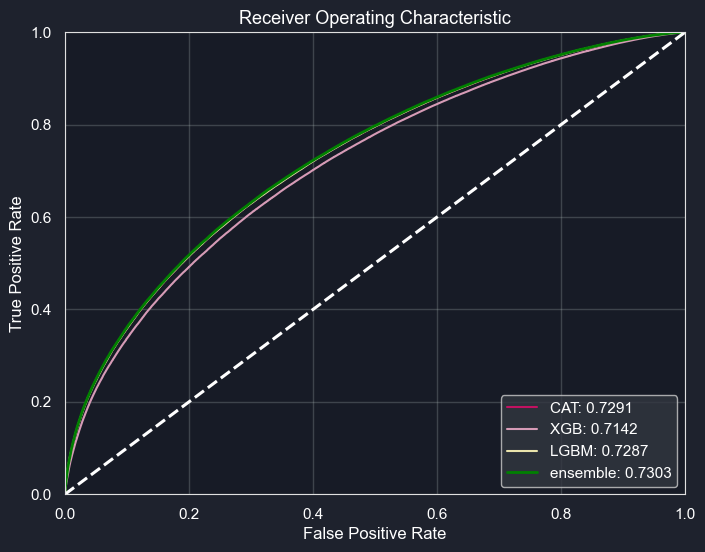

In [144]:
tr.plot_curve()

In [147]:
y_preds = (tr.evaluate(test_eng))

In [148]:
def create_submission(y_preds, file_name):
    submission = pd.read_sql('SELECT * FROM sample_submission', config.engine)
    submission[config.target_name] = y_preds
    path = config.path_submissions+'/'+file_name+'.csv'
    
    submission.to_csv(path, index=False)

# y_preds = T.predict_proba(test)
create_submission(y_preds, 'ensemble_1')